# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
#pip install phik shap mlxtend pandas==2.2.2 scikit-learn==1.5.1. matplotlib==3.7.3 seaborn==0.13.2 scipy==1.13.1 -q

In [2]:
import pandas as pd
import numpy as np
import sklearn
import scipy
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.multiclass import type_of_target

from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    recall_score, 
    f1_score, 
    roc_curve, 
    roc_auc_score, 
    fbeta_score, 
    make_scorer, 
    root_mean_squared_error, 
    mean_squared_error, 
    mean_absolute_error
)

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV,
    KFold
) 

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    OneHotEncoder,
    LabelEncoder, 
    OrdinalEncoder    
)

from sklearn.feature_selection import (
    SelectKBest, 
    f_classif, 
    mutual_info_classif, 
    chi2
) 

from mlxtend.plotting import plot_decision_regions
from itertools import combinations
from statsmodels.stats.outliers_influence import variance_inflation_factor  
import statsmodels.api as sm
from scipy import stats, optimize, interpolate
import scipy.stats.mvn
import phik
from phik.report import plot_correlation_matrix
import shap
shap.plots.initjs()
import math
import re
import random
%matplotlib inline
#%matplotlib notebook
pd.options.mode.chained_assignment = None
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

## Загрузка и подготовка данных

### Просмотр набора данных

In [3]:
# geo_data_0 = pd.read_csv(r'/datasets/geo_data_0.csv', delimiter=',', decimal='.')
# geo_data_1 = pd.read_csv(r'/datasets/geo_data_1.csv', delimiter=',', decimal='.')
# geo_data_2 = pd.read_csv(r'/datasets/geo_data_2.csv', delimiter=',', decimal='.')

In [4]:
geo_data_0 = pd.read_csv(r'C:\Users\user\geo_data_0.csv', delimiter=',', decimal='.')
geo_data_1 = pd.read_csv(r'C:\Users\user\geo_data_1.csv', delimiter=',', decimal='.')
geo_data_2 = pd.read_csv(r'C:\Users\user\geo_data_2.csv', delimiter=',', decimal='.')

In [5]:
for i in(geo_data_0, geo_data_1, geo_data_2):
    display(i.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Вывод общей информации о наборах данных

In [6]:
for i in(geo_data_0, geo_data_1, geo_data_2):
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

### Вывод размерности наборов данных

In [7]:
for i in(geo_data_0, geo_data_1, geo_data_2):
    display(i.shape)

(100000, 5)

(100000, 5)

(100000, 5)

**Выводы после первичного просмотра наборов данных:**

1. Для исследовательской работы были загружены все три набора данных, и проведена работа по разбиению строковых значений методом delimiter и decimal.

2. Наименования столбцов приведены к нижнему регистру. Одинаковые наименования столбцов в разных наборах данных совпадают.

### Предобработка данных

**Работа с пропусками**

In [8]:
for i in(geo_data_0, geo_data_1, geo_data_2):
    display(i.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропусков в наборах данных не имеется.

**Работа с дубликатами**

In [9]:
for i in(geo_data_0, geo_data_1, geo_data_2):
    display(i.duplicated().sum())

0

0

0

Дубликатов в наборах данных не имеется.

**Работа с типами данных**

In [10]:
for i in(geo_data_0, geo_data_1, geo_data_2):
    display(i.dtypes)

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

Все значения с плавающей точкой приведены к типу 'float'.

### Исследовательский анализ данных

**Основные показатели описательской статистики**

In [11]:
for i in(geo_data_0, geo_data_1, geo_data_2):
    display(i.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Визуализация признаков в наборе данных 'geo_data_0'**

<Figure size 1800x1800 with 0 Axes>

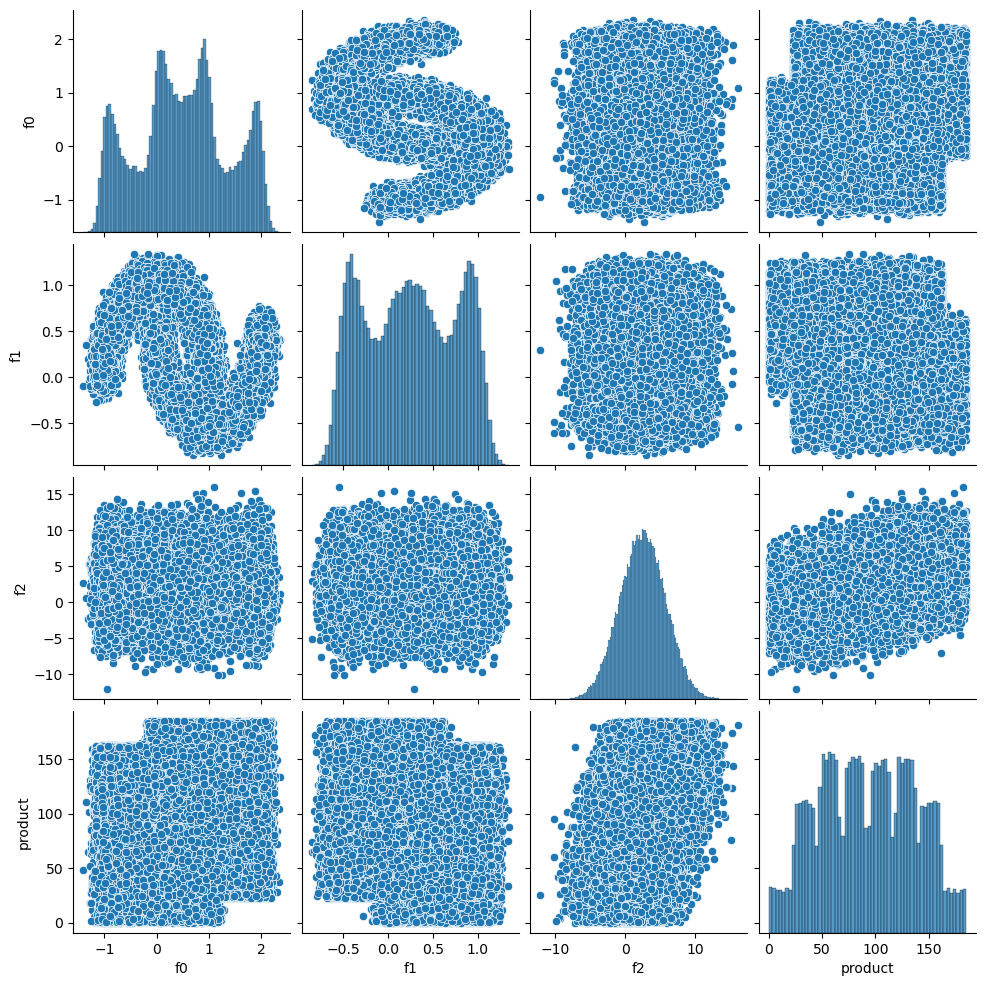

In [12]:
plt.figure(figsize=(18, 18))
sns.pairplot(data=geo_data_0)
plt.show(close=None, block=None)

**Визуализация признаков в наборе данных 'geo_data_1'**

<Figure size 1800x1800 with 0 Axes>

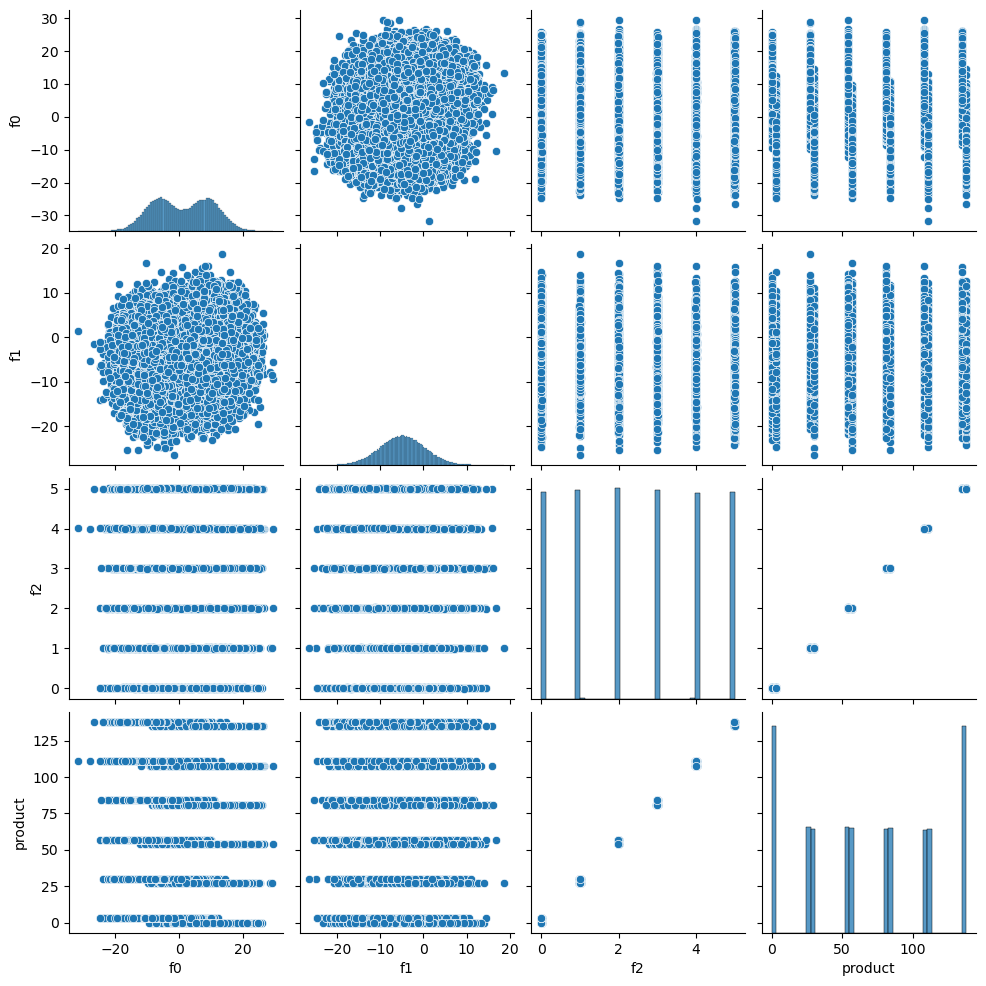

In [13]:
plt.figure(figsize=(18, 18))
sns.pairplot(data=geo_data_1)
plt.show(close=None, block=None)

**Визуализация признаков в наборе данных 'geo_data_2'**

<Figure size 1800x1800 with 0 Axes>

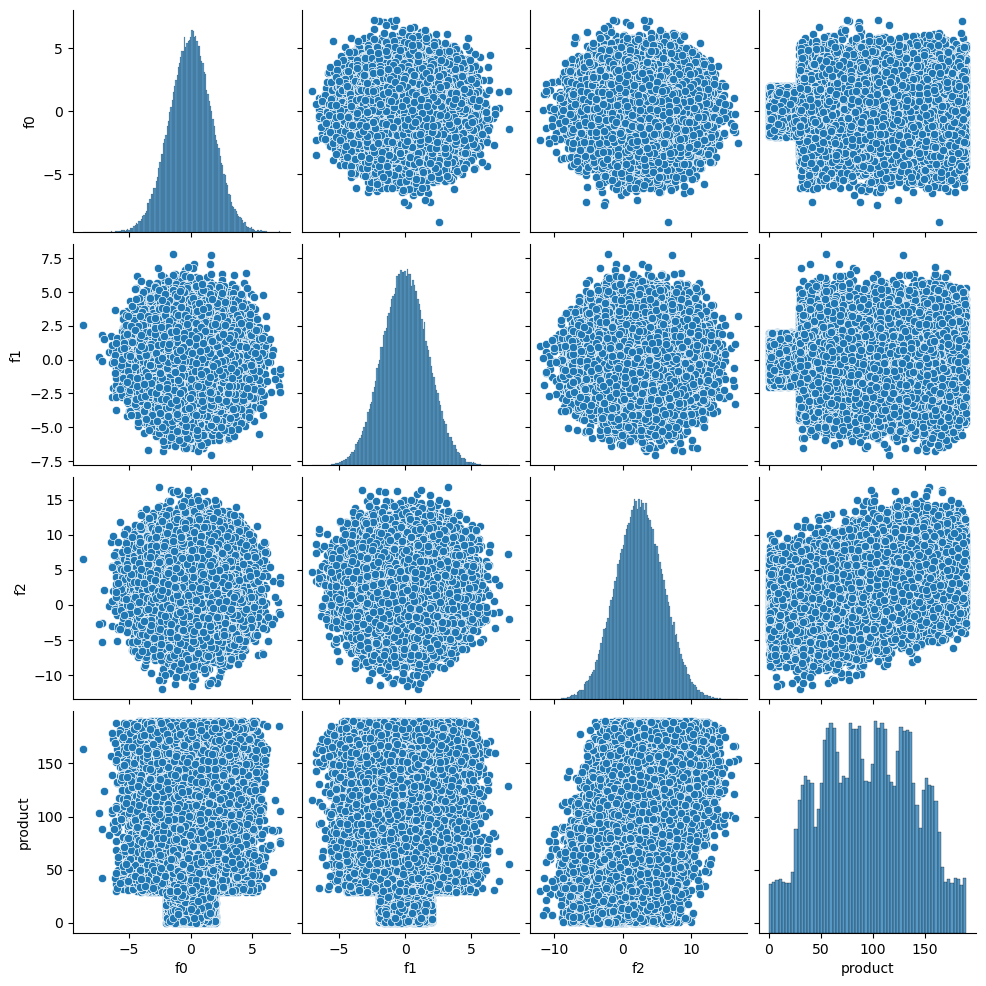

In [14]:
plt.figure(figsize=(18, 18))
sns.pairplot(data=geo_data_2)
plt.show(close=None, block=None)

**Вывод:**

1. Необычная зависимость наблюдается только в регионе 1 между целевым признаком 'product' и признаком 'f2'.

2. В остальных признаках линейной зависимости не наблюдается.

### Целевой показатель 'product'

**Набор данных 'geo_data_0'**

In [15]:
geo_data_0['product'].describe()

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

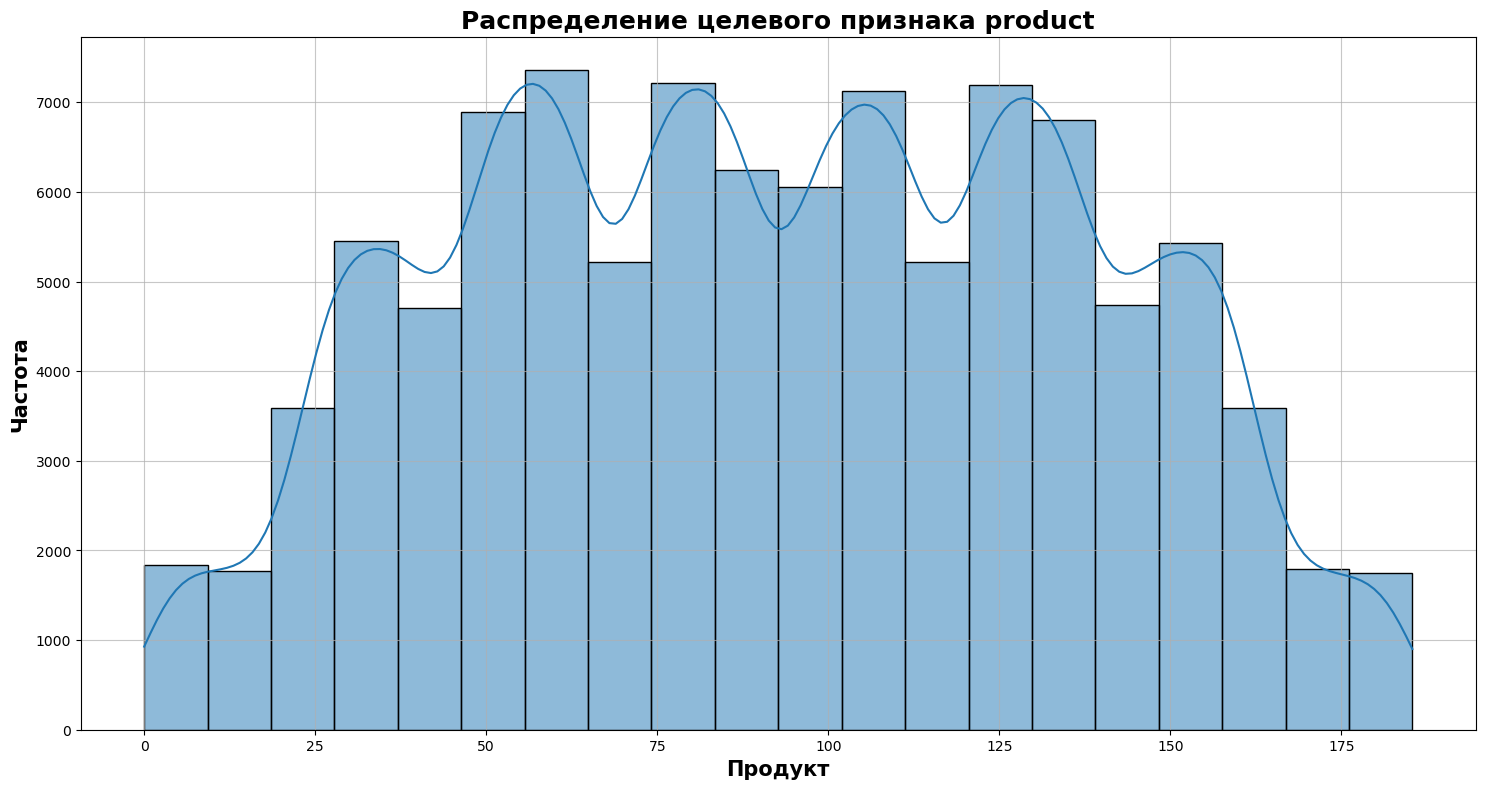

In [16]:
fig, ax = plt.subplots(figsize=(18, 9))
sns.histplot(data=geo_data_0, x='product', bins=20, kde=True)
ax.set_title('Распределение целевого признака product', fontsize=18, fontweight='bold')
ax.set_xlabel('Продукт', fontsize=15, fontweight='bold')
ax.set_ylabel('Частота', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

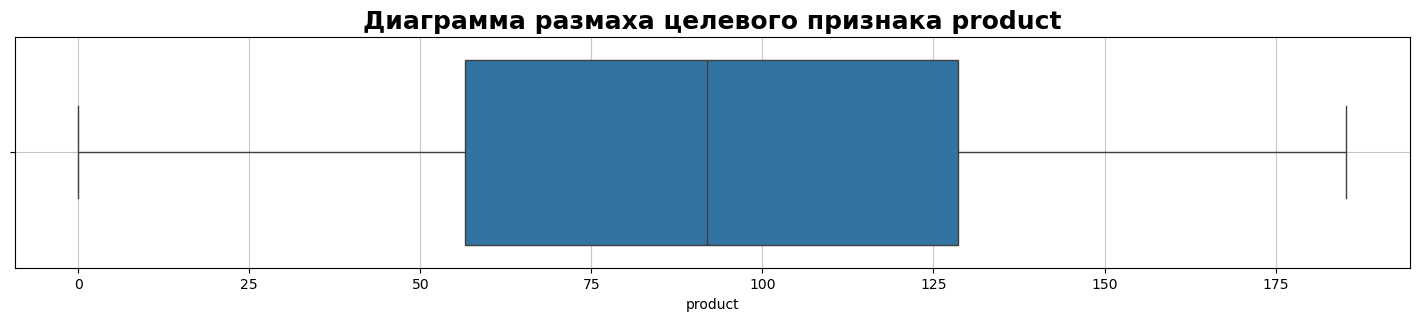

In [17]:
fig, ax = plt.subplots(figsize=(18, 3))
sns.boxplot(data=geo_data_0, x='product', orient='h')
ax.set_title('Диаграмма размаха целевого признака product', fontsize=18, fontweight='bold')
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

**Набор данных 'geo_data_1'**

In [18]:
geo_data_1['product'].describe()

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

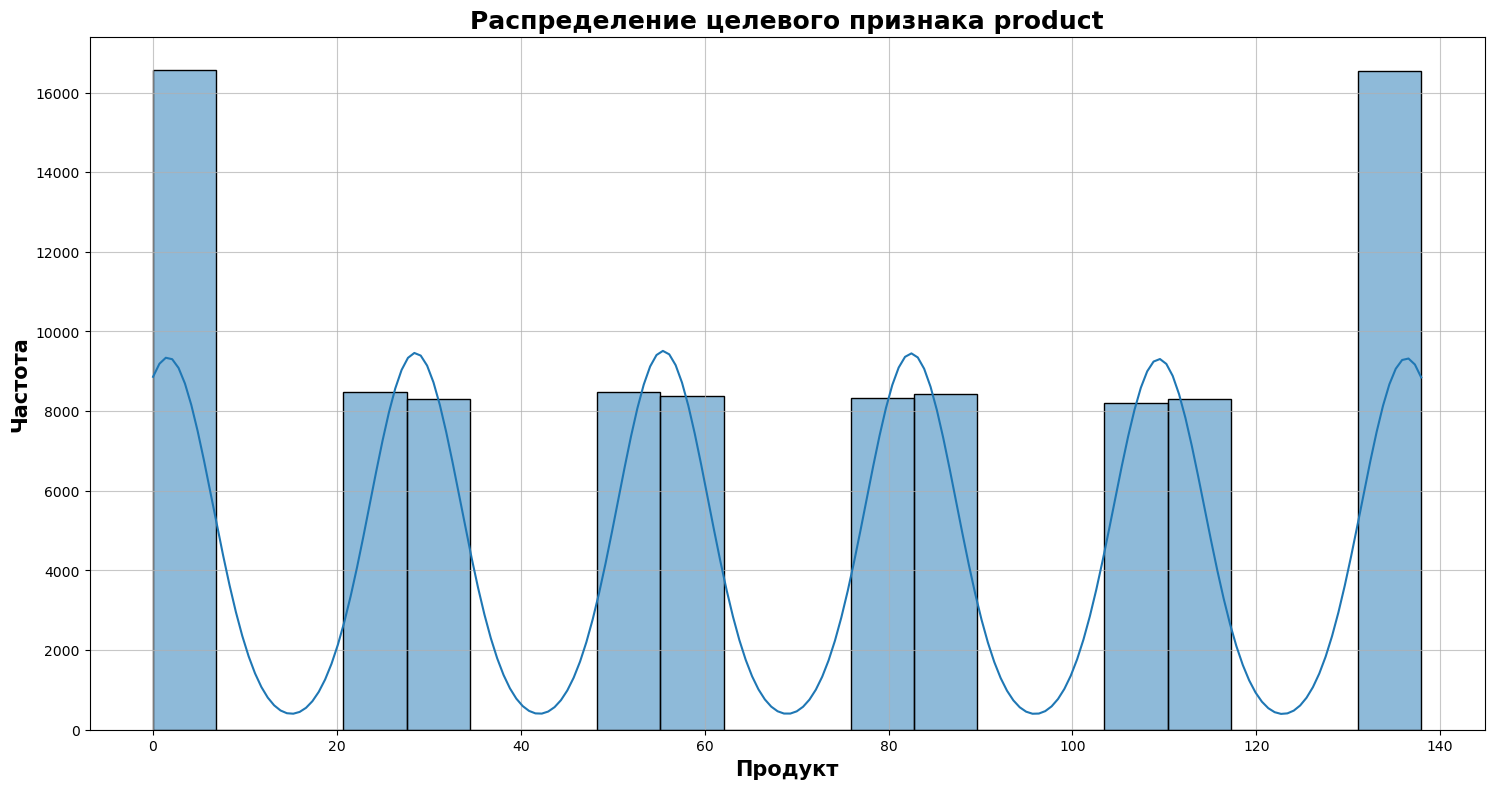

In [19]:
fig, ax = plt.subplots(figsize=(18, 9))
sns.histplot(data=geo_data_1, x='product', bins=20, kde=True)
ax.set_title('Распределение целевого признака product', fontsize=18, fontweight='bold')
ax.set_xlabel('Продукт', fontsize=15, fontweight='bold')
ax.set_ylabel('Частота', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

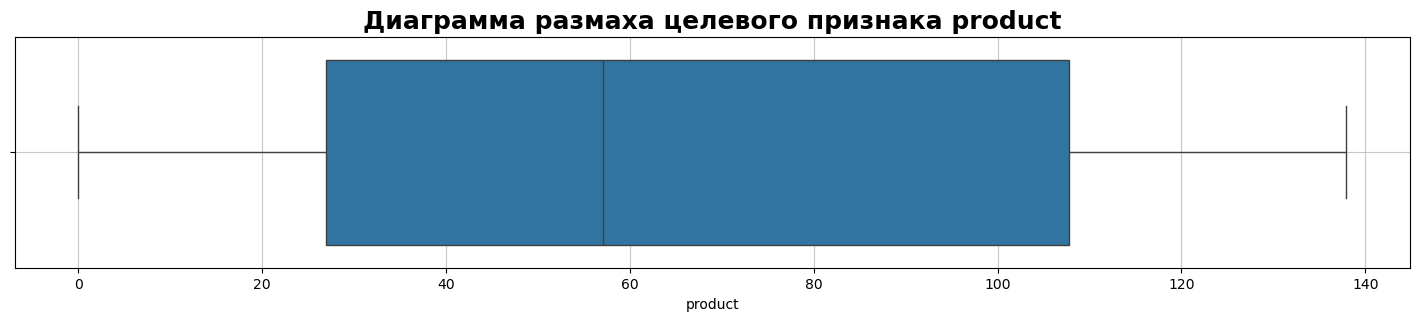

In [20]:
fig, ax = plt.subplots(figsize=(18, 3))
sns.boxplot(data=geo_data_1, x='product', orient='h')
ax.set_title('Диаграмма размаха целевого признака product', fontsize=18, fontweight='bold')
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

**Набор данных 'geo_data_2'**

In [21]:
geo_data_2['product'].describe()

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

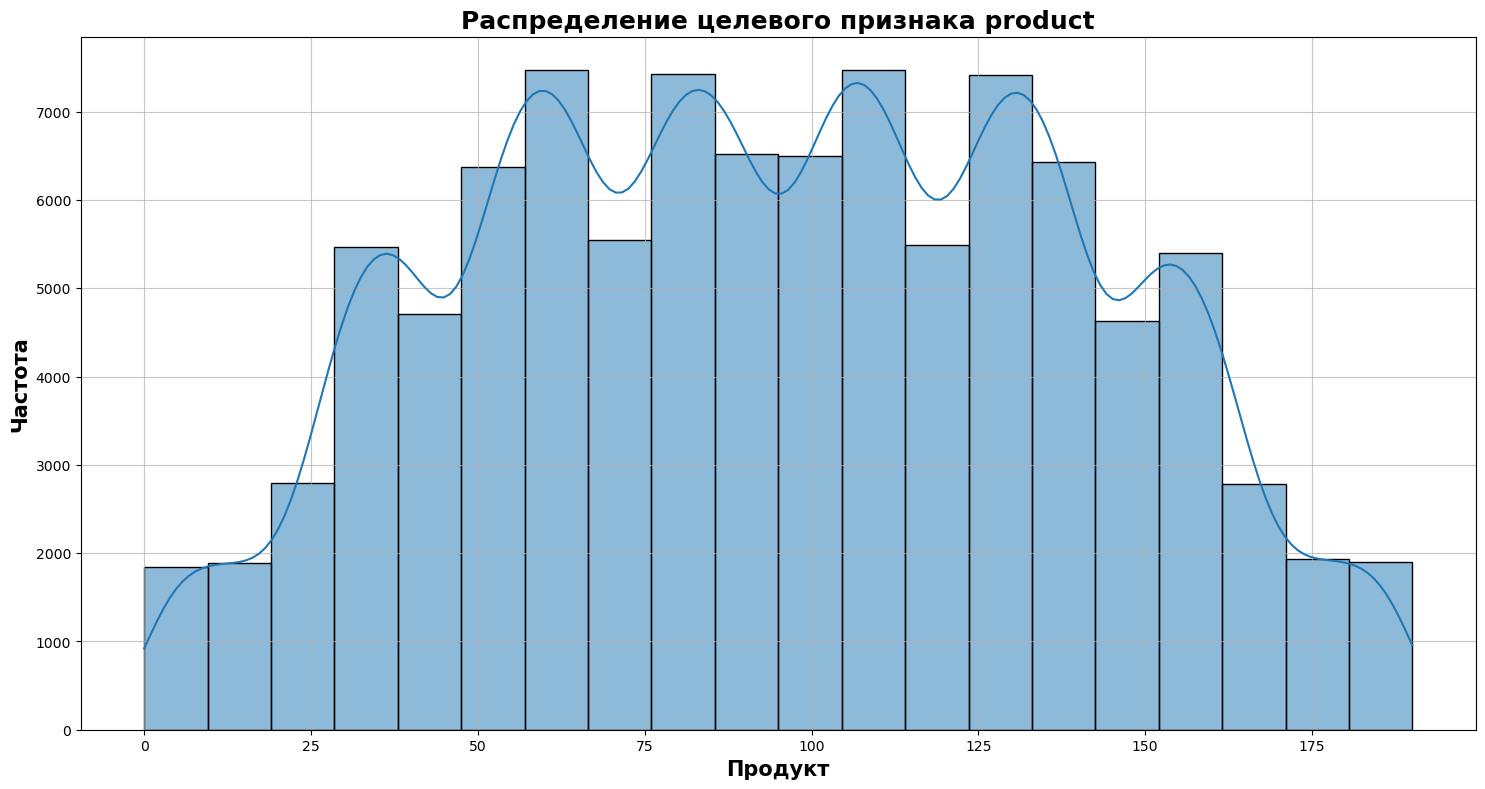

In [22]:
fig, ax = plt.subplots(figsize=(18, 9))
sns.histplot(data=geo_data_2, x='product', bins=20, kde=True)
ax.set_title('Распределение целевого признака product', fontsize=18, fontweight='bold')
ax.set_xlabel('Продукт', fontsize=15, fontweight='bold')
ax.set_ylabel('Частота', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

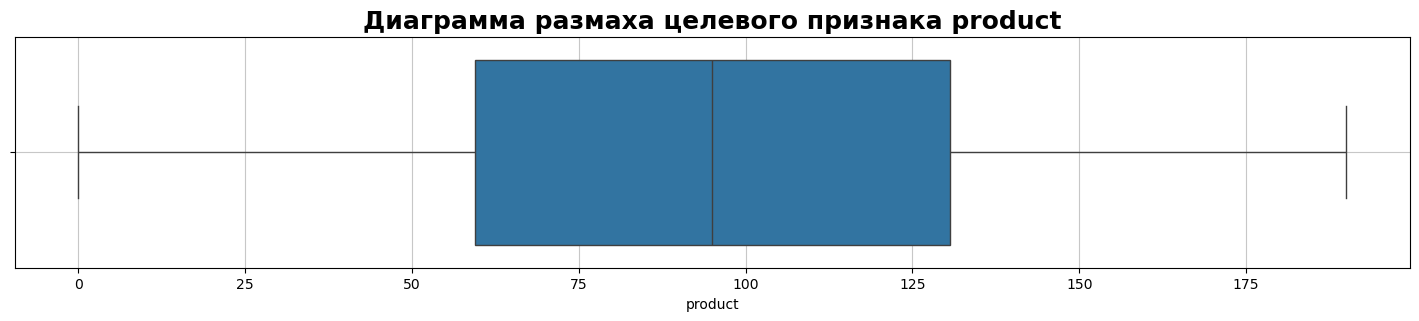

In [23]:
fig, ax = plt.subplots(figsize=(18, 3))
sns.boxplot(data=geo_data_2, x='product', orient='h')
ax.set_title('Диаграмма размаха целевого признака product', fontsize=18, fontweight='bold')
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

**Выводы:**

1. Месторождения geo_data_0 и geo_data_2 имеют нормальное распределение, их средние и медианные значения примерно одинаковы.

2. Месторождение geo_data_1 имеет ненормальное распредление, его среднее значение заметно выше медианного и при этом выбросов в признаке не имеется. 

### Корреляционный анализ

**Набор данных 'geo_data_0'**

In [24]:
geo_data_0_corr = geo_data_0.drop(columns=['id'], axis=1)

In [25]:
matrix_0 = geo_data_0_corr.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
matrix_0.round(2)

,f0,f1,f2,product
f0,1.00,0.76,0.00,0.22
f1,0.76,1.00,0.00,0.25
f2,0.00,0.00,1.00,0.48
product,0.22,0.25,0.48,1.00


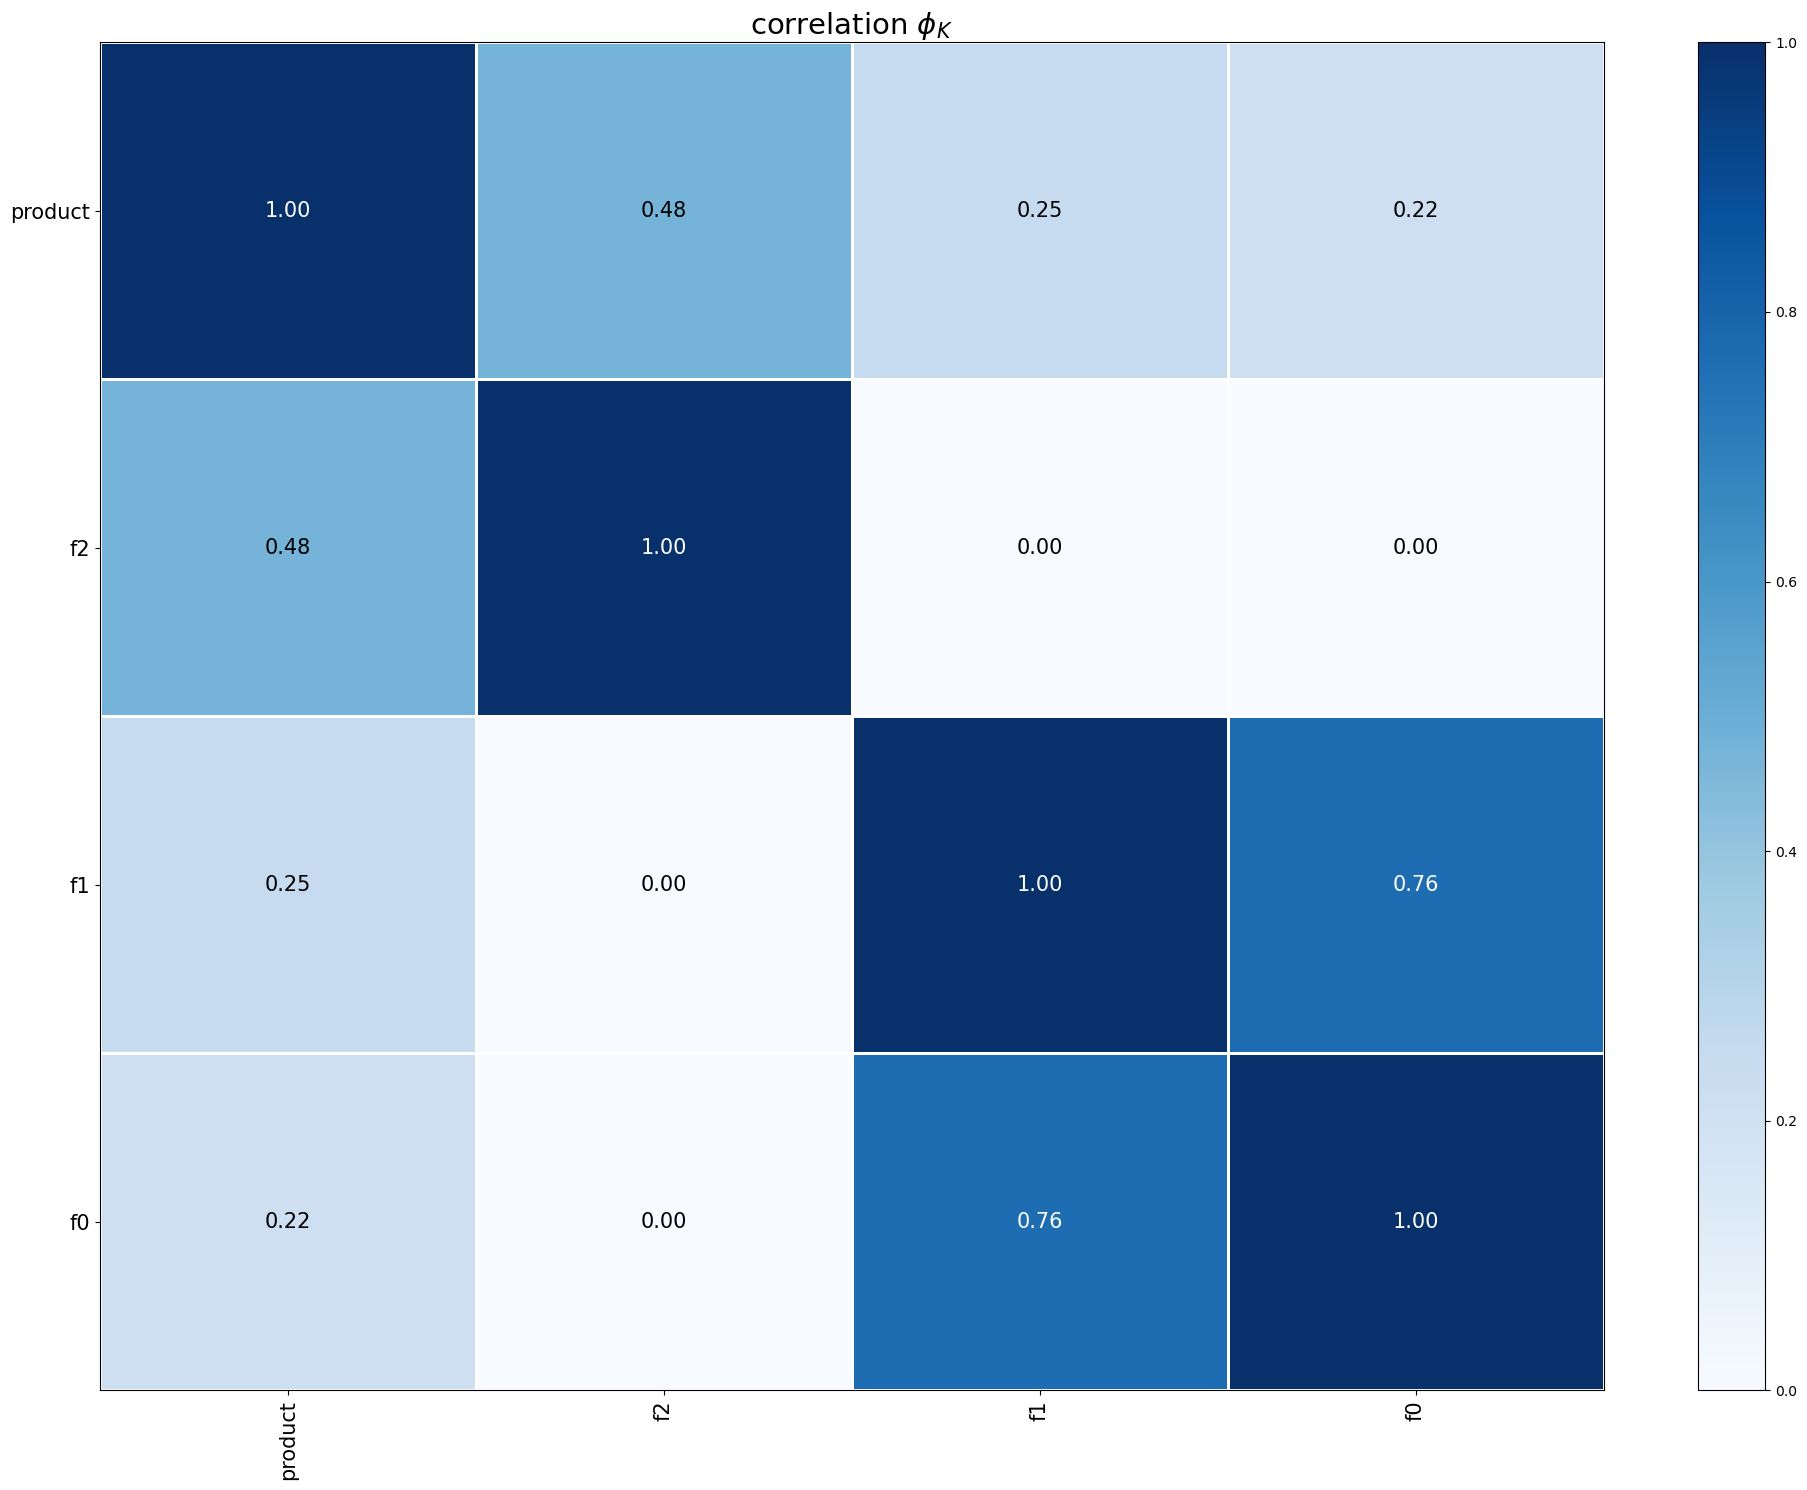

In [26]:
plot_correlation_matrix(
    matrix_0.values,
    x_labels=matrix_0.columns,
    y_labels=matrix_0.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

**Набор данных 'geo_data_1'**

In [27]:
geo_data_1_corr = geo_data_1.drop(columns=['id'], axis=1)

In [28]:
matrix_1 = geo_data_1_corr.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
matrix_1.round(2)

,f0,f1,f2,product
f0,1.00,0.20,0.00,0.63
f1,0.20,1.00,0.00,0.19
f2,0.00,0.00,1.00,0.98
product,0.63,0.19,0.98,1.00


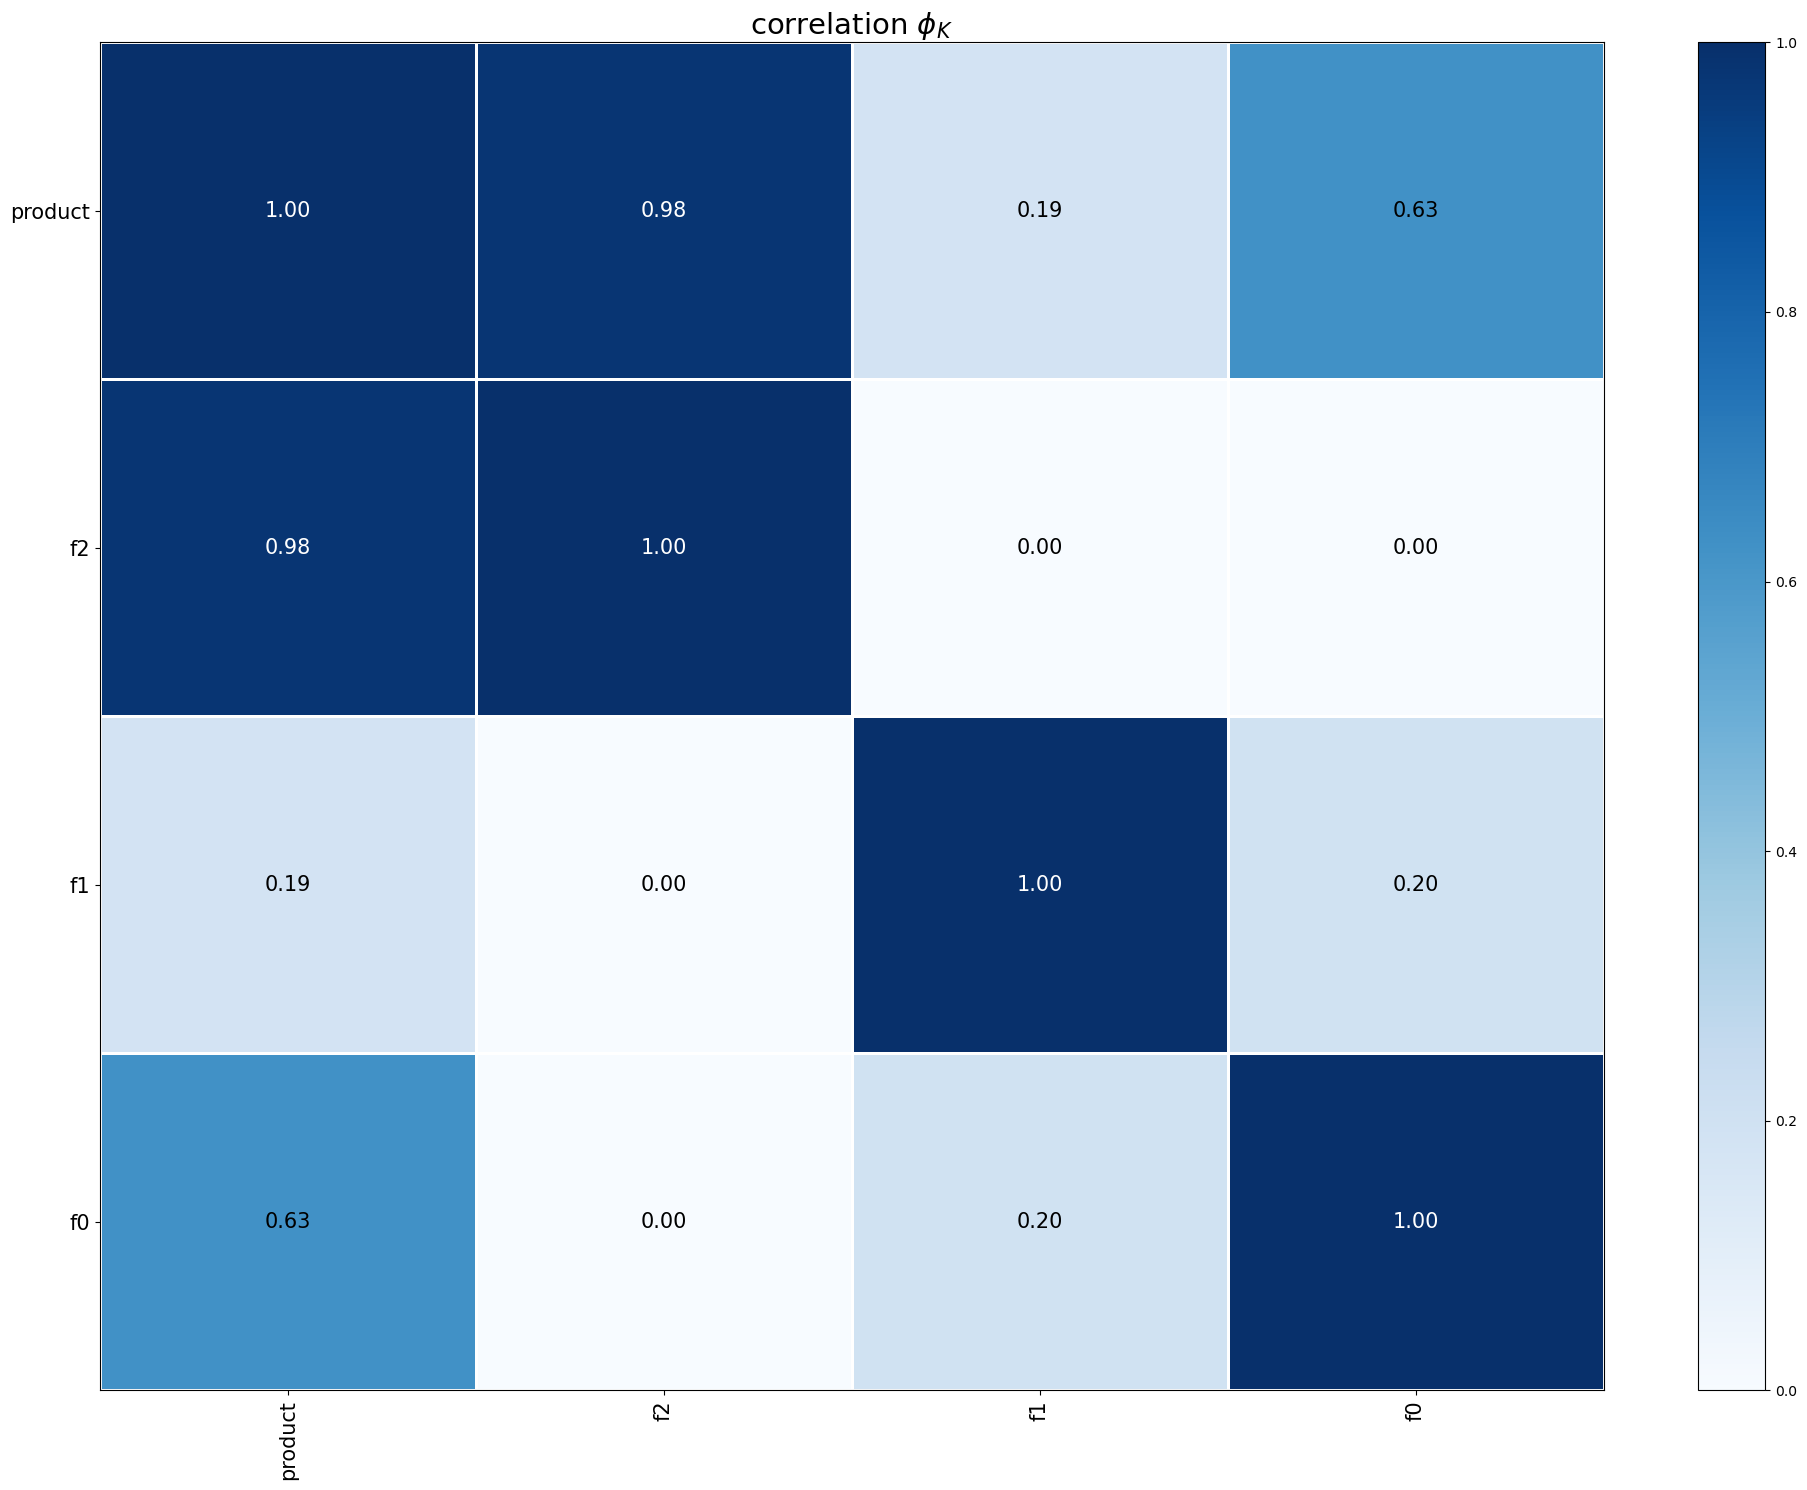

In [29]:
plot_correlation_matrix(
    matrix_1.values,
    x_labels=matrix_1.columns,
    y_labels=matrix_1.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

**Набор данных 'geo_data_2'**

In [30]:
geo_data_2_corr = geo_data_2.drop(columns=['id'], axis=1)

In [31]:
matrix_2 = geo_data_2_corr.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
matrix_2.round(2)

,f0,f1,f2,product
f0,1.0,0.00,0.00,0.20
f1,0.0,1.00,0.00,0.22
f2,0.0,0.00,1.00,0.44
product,0.2,0.22,0.44,1.00


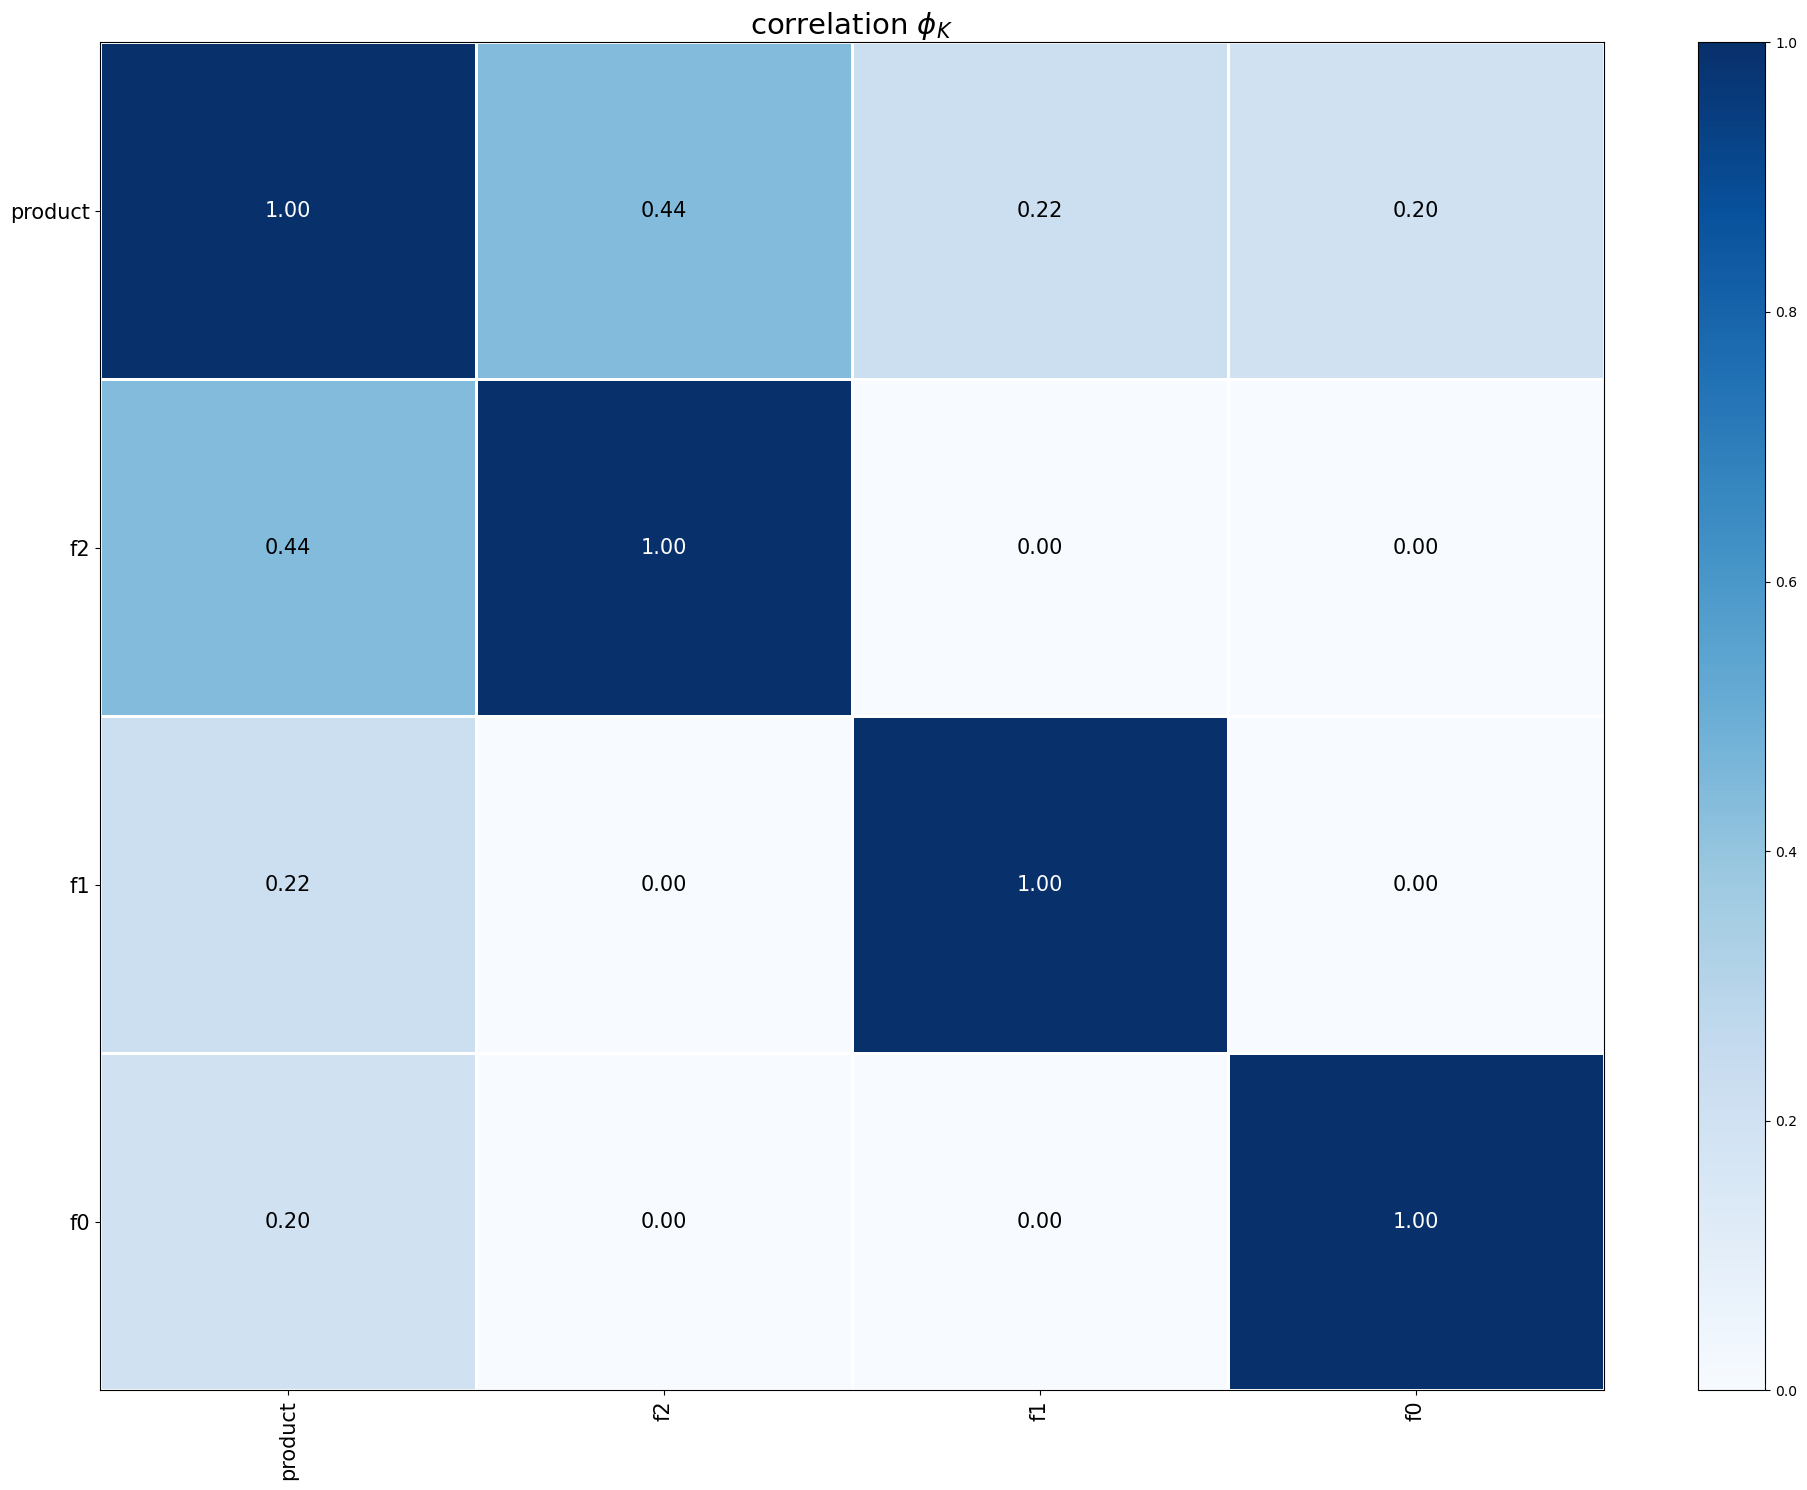

In [32]:
plot_correlation_matrix(
    matrix_2.values,
    x_labels=matrix_2.columns,
    y_labels=matrix_2.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

**Выводы:**

1. В регионе 0 наибольшая корреляция - средняя у целевого показателя с признаком 'f2' (0.48), у оставшихся признаков корреляция слабая. В регионе 2 аналогичная ситуация и наибольшая корреляция - средняя у целевого показателя с признаком 'f2' (0.44) и слабая у оставшихся признаков.

1. В регионе 1 целевая переменная имеет очень сильную корреляцию с признаком 'f2' (0.98). При такой корреляции переменные не предоставляют уникальную или независимую информацию в регрессионной модели.

### Проверка мультиколлинеарности и расчет коэффициента VIF

**Регион 0**

In [33]:
job_corr_vif_0 = geo_data_0_corr[['f0', 'f1', 'f2', 'product']]

X = sm.add_constant(job_corr_vif_0)

vif = pd.DataFrame()
vif['Переменная'] = X.columns
vif['Коэффициент VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(vif)

,Переменная,Коэффициент VIF
0,const,6.861281
1,f0,1.248703
2,f1,1.276589
3,f2,1.323671
4,product,1.380659


**Регион 1**

In [34]:
job_corr_vif_1 = geo_data_1_corr[['f0', 'f1', 'f2', 'product']]

X = sm.add_constant(job_corr_vif_1)

vif = pd.DataFrame()
vif['Переменная'] = X.columns
vif['Коэффициент VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(vif)

,Переменная,Коэффициент VIF
0,const,7.561536
1,f0,3.163234
2,f1,1.049803
3,f2,2660.141618
4,product,2662.652617


**Регион 2**

In [35]:
job_corr_vif_2 = geo_data_2_corr[['f0', 'f1', 'f2', 'product']]

X = sm.add_constant(job_corr_vif_2)

vif = pd.DataFrame()
vif['Переменная'] = X.columns
vif['Коэффициент VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(vif)

,Переменная,Коэффициент VIF
0,const,5.571816
1,f0,1.000004
2,f1,1.000003
3,f2,1.248132
4,product,1.248137


**Выводы:**

1. В регионе 1 признак 'f2' имеет очень большую мультиколлинеарность (у которого ранее было выявлено необычное распределение и высокая корреляция). Использование этого признака в дальнейшем при построении моделей может привести к искаженным или вводящим в заблуждение результатам. Но, данный признак удалять не будем в соответствии с техническим заданием.

2. В регионе 0 и регионе 2 большой мультиколлинеарности не наблюдается. 

## Обучение и проверка модели

### Подготовка данных для обучения моделей

Подготовка наборов данных и удаление признака 'id'

In [36]:
model_0 = geo_data_0.drop('id', axis=1)
model_1 = geo_data_1.drop('id', axis=1)
model_2 = geo_data_2.drop('id', axis=1)

Определение целевого и входных признаков, разделение на тренировочную и валидационную выборки

In [37]:
RANDOM_STATE = 42

def split(data):
    X = data.drop(['product'], axis=1)
    y = data['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    return X_train, X_valid, y_train, y_valid

In [38]:
X_0_train, X_0_valid, y_0_train, y_0_valid = split(model_0)
X_1_train, X_1_valid, y_1_train, y_1_valid = split(model_1)
X_2_train, X_2_valid, y_2_train, y_2_valid = split(model_2)

### Регион 0

Проверим размерность выборок

In [39]:
data_shape = {'Выборка': ['X_0_train', 'X_0_valid', 'y_0_train', 'y_0_valid'], 
            'Размер': [X_0_train.shape, X_0_valid.shape, y_0_train.shape, y_0_valid.shape]}

display(pd.DataFrame(data_shape))

,Выборка,Размер
0,X_0_train,"(75000, 3)"
1,X_0_valid,"(25000, 3)"
2,y_0_train,"(75000,)"
3,y_0_valid,"(25000,)"


In [40]:
num_columns = ['f0', 'f1', 'f2']

Масштабирование количественных признаков

In [41]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_0_train[num_columns])
X_valid_scaled = scaler.transform(X_0_valid[num_columns])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_columns)

X_train = pd.concat([X_train_scaled], axis=1)
X_test = pd.concat([X_valid_scaled], axis=1)

Создаем и обучаем молель линейной регрессии

In [42]:
model_lr0 = LinearRegression()
model_lr0.fit(X_0_train, y_0_train)

LinearRegression()

In [43]:
predictions_0 = model_lr0.predict(X_0_valid)

In [44]:
df_0 = pd.DataFrame({'Действительный' : y_0_valid, 'Прогнозируемый' : predictions_0})
df_0.head()

,Действительный,Прогнозируемый
75721,122.073350,101.901017
80184,48.738540,78.217774
19864,131.338088,115.266901
76699,88.327757,105.618618
92991,36.959266,97.980185


In [45]:
X_0_valid['predictions'] = predictions_0

Сохраняем предсказания на валидационной выборке

In [46]:
X_0_valid.head()

,f0,f1,f2,predictions
75721,0.599283,-0.557623,2.121187,101.901017
80184,0.739017,-0.463156,-1.347584,78.217774
19864,1.422743,-0.534917,3.718798,115.266901
76699,1.580244,-0.238458,2.805149,105.618618
92991,0.918974,0.023961,2.598575,97.980185


Проверка модели различными метриками и вывод среднего запаса сырья в регионе

In [47]:
print(f'Средняя абсолютная ошибка (MAE): {mean_absolute_error(y_0_valid, predictions_0)}')
print()
print(f'Среднеквадратичная ошибка (MSE): {mean_squared_error(y_0_valid, predictions_0)}')
print()
print(f'Корень из среднеквадратичной ошибки (RMSE): {root_mean_squared_error(y_0_valid, predictions_0)}')
print()
print(f'Коэффициент детерминации (R2): {r2_score(y_0_valid, predictions_0)}')
print()
print(f'Средний запас предсказанного сырья в регионе: {predictions_0.mean()}')

Средняя абсолютная ошибка (MAE): 31.04768153878818

Среднеквадратичная ошибка (MSE): 1425.5608700093812

Корень из среднеквадратичной ошибки (RMSE): 37.75660035026169

Коэффициент детерминации (R2): 0.2728287328173471

Средний запас предсказанного сырья в регионе: 92.39879990657768


### Регион 1

Проверим размерность выборок

In [48]:
data_shape = {'Выборка': ['X_1_train', 'X_1_valid', 'y_1_train', 'y_1_valid'], 
            'Размер': [X_1_train.shape, X_1_valid.shape, y_1_train.shape, y_1_valid.shape]}

display(pd.DataFrame(data_shape))

,Выборка,Размер
0,X_1_train,"(75000, 3)"
1,X_1_valid,"(25000, 3)"
2,y_1_train,"(75000,)"
3,y_1_valid,"(25000,)"


In [49]:
num_columns = ['f0', 'f1', 'f2']

Масштабирование количественных признаков

In [50]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_1_train[num_columns])
X_valid_scaled = scaler.transform(X_1_valid[num_columns])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_columns)

X_train = pd.concat([X_train_scaled], axis=1)
X_test = pd.concat([X_valid_scaled], axis=1)

Создаем и обучаем молель линейной регрессии

In [51]:
model_lr1 = LinearRegression()
model_lr1.fit(X_1_train, y_1_train)

LinearRegression()

In [52]:
predictions_1 = model_lr1.predict(X_1_valid)

In [53]:
df_1 = pd.DataFrame({'Действительный' : y_1_valid, 'Прогнозируемый' : predictions_1})
df_1.head()

,Действительный,Прогнозируемый
75721,0.000000,0.844738
80184,53.906522,52.921612
19864,134.766305,135.110385
76699,107.813044,109.494863
92991,0.000000,-0.047292


In [54]:
X_1_valid['predictions'] = predictions_1

Сохраняем предсказания на валидационной выборке

In [55]:
X_1_valid.head()

,f0,f1,f2,predictions
75721,6.078076,0.084568,0.002957,0.844738
80184,16.462386,2.712946,1.993030,52.921612
19864,7.051898,0.766983,4.990194,135.110385
76699,-0.240045,-0.380804,3.999693,109.494863
92991,13.350111,-8.558281,0.002010,-0.047292


Проверка модели различными метриками и вывод среднего запаса сырья в регионе

In [56]:
print(f'Средняя абсолютная ошибка (MAE): {mean_absolute_error(y_1_valid, predictions_1)}')
print()
print(f'Среднеквадратичная ошибка (MSE): {mean_squared_error(y_1_valid, predictions_1)}')
print()
print(f'Корень из среднеквадратичной ошибки (RMSE): {root_mean_squared_error(y_1_valid, predictions_1)}')
print()
print(f'Коэффициент детерминации (R2): {r2_score(y_1_valid, predictions_1)}')
print()
print(f'Средний запас предсказанного сырья в регионе: {predictions_1.mean()}')

Средняя абсолютная ошибка (MAE): 0.7170119535682554

Среднеквадратичная ошибка (MSE): 0.7925986566392014

Корень из среднеквадратичной ошибки (RMSE): 0.8902801001028842

Коэффициент детерминации (R2): 0.9996245232002449

Средний запас предсказанного сырья в регионе: 68.71287803913762


### Регион 2

Проверим размерность выборок

In [57]:
data_shape = {'Выборка': ['X_2_train', 'X_2_valid', 'y_2_train', 'y_2_valid'], 
            'Размер': [X_2_train.shape, X_2_valid.shape, y_2_train.shape, y_2_valid.shape]}

display(pd.DataFrame(data_shape))

,Выборка,Размер
0,X_2_train,"(75000, 3)"
1,X_2_valid,"(25000, 3)"
2,y_2_train,"(75000,)"
3,y_2_valid,"(25000,)"


In [58]:
num_columns = ['f0', 'f1', 'f2']

Масштабирование количественных признаков

In [59]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_2_train[num_columns])
X_valid_scaled = scaler.transform(X_2_valid[num_columns])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_columns)

X_train = pd.concat([X_train_scaled], axis=1)
X_test = pd.concat([X_valid_scaled], axis=1)

Создаем и обучаем молель линейной регрессии

In [60]:
model_lr2 = LinearRegression()
model_lr2.fit(X_2_train, y_2_train)

LinearRegression()

In [61]:
predictions_2 = model_lr2.predict(X_2_valid)

In [62]:
df_2 = pd.DataFrame({'Действительный' : y_2_valid, 'Прогнозируемый' : predictions_2})
df_2.head()

,Действительный,Прогнозируемый
75721,117.441301,98.301916
80184,47.841249,101.592461
19864,45.883483,52.449099
76699,139.014608,109.922127
92991,84.004276,72.411847


In [63]:
X_2_valid['predictions'] = predictions_2

Сохраняем предсказания на валидационной выборке

In [64]:
X_2_valid.head()

,f0,f1,f2,predictions
75721,2.111118,-1.679773,3.112240,98.301916
80184,0.734759,0.747788,3.670879,101.592461
19864,-2.513109,0.844631,-4.922889,52.449099
76699,-2.035301,-1.522988,5.072839,109.922127
92991,2.744145,1.429952,-1.372661,72.411847


Проверка модели различными метриками и вывод среднего запаса сырья в регионе

In [65]:
print(f'Средняя абсолютная ошибка (MAE): {mean_absolute_error(y_2_valid, predictions_2)}')
print()
print(f'Среднеквадратичная ошибка (MSE): {mean_squared_error(y_2_valid, predictions_2)}')
print()
print(f'Корень из среднеквадратичной ошибки (RMSE): {root_mean_squared_error(y_2_valid, predictions_2)}')
print()
print(f'Коэффициент детерминации (R2): {r2_score(y_2_valid, predictions_2)}')
print()
print(f'Средний запас предсказанного сырья в регионе: {predictions_2.mean()}')

Средняя абсолютная ошибка (MAE): 32.896958610578054

Среднеквадратичная ошибка (MSE): 1611.6910636385903

Корень из среднеквадратичной ошибки (RMSE): 40.145872311342174

Коэффициент детерминации (R2): 0.19634705977280487

Средний запас предсказанного сырья в регионе: 94.77102387765936


**Итоговая таблица**

In [66]:
result_1 = pd.DataFrame({'Метрика MAE': [mean_absolute_error(y_0_valid, predictions_0), 
                                       mean_absolute_error(y_1_valid, predictions_1), 
                                       mean_absolute_error(y_2_valid, predictions_2)], 
                       'Метрика MSE': [mean_squared_error(y_0_valid, predictions_0), 
                                       mean_squared_error(y_1_valid, predictions_1), 
                                       mean_squared_error(y_2_valid, predictions_2)], 
                       'Метрика RMSE': [root_mean_squared_error(y_0_valid, predictions_0), 
                                        root_mean_squared_error(y_1_valid, predictions_1), 
                                        root_mean_squared_error(y_2_valid, predictions_2)], 
                       'Метрика R2': [r2_score(y_0_valid, predictions_0), 
                                      r2_score(y_1_valid, predictions_1), 
                                      r2_score(y_2_valid, predictions_2)], 
                       'Средний запас': [predictions_0.mean(), predictions_1.mean(),predictions_2.mean()]}, 
                      index=['Модель 0', 'Модель 1', 'Модель 2'])

result_1

,Метрика MAE,Метрика MSE,Метрика RMSE,Метрика R2,Средний запас
Модель 0,31.047682,1425.560870,37.756600,0.272829,92.398800
Модель 1,0.717012,0.792599,0.890280,0.999625,68.712878
Модель 2,32.896959,1611.691064,40.145872,0.196347,94.771024


**Вывод:**

1. В регионах 0 и 2 наблюдаются самые высокие средние запасы предсказанного сырья 92.3 и 94.7 соответственно, и у этих регионов не самые высокие показатели метрики RMSE. Модель в среднем ошибается в модели 0 на 37.7 тыс. баррелей и в модели 2 на 40.1 тыс. баррелей.

2. В регионе 1 наблюдается самое низкое и лучшее значение метрики RMSE (0.89), но более низкий средний запас (68.8 тыс. баррелей). 

3. В целом регион 1 является ниболее предпочтительным, так как имеет лучший показатель RMSE и модель всего ошибается на 0.8 баррелей.

## Подготовка к расчёту прибыли

**Определение констант**

In [67]:
BUDGET = 10_000_000_000 
POINTS = 500 
BEST_POINTS = 200 
PRICE = 450
ONE_PRICE = 50_000_000
PRODUCT_PRICE = 450_000
BOOTSTRAP_SAMPLES = 1000 
STATE = np.random.RandomState(12345)

In [68]:
min_volume = (BUDGET / BEST_POINTS) / PRODUCT_PRICE
print(f'Достаточный объем сырья для безубыточной разработки новой скважины составляет: {min_volume}')

Достаточный объем сырья для безубыточной разработки новой скважины составляет: 111.11111111111111


**Вывод:**

1. Средний запас сырья в каждом регионе (регион 0 - 92.3, регион 1 - 94.7, регион 2 - 68.8) не соответствуют достаточному объему сырья для безубыточной разработки. Все регионы убыточные.

## Расчёт прибыли и рисков 

**Написание функции и расчет прибыли**

In [69]:
def revenue(target, probabilities,count):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities).reset_index(drop=True)
    probs_sorted = probabilities.sort_values(ascending=False) 
    selected = target[probs_sorted.index][:BEST_POINTS]
    return ((PRODUCT_PRICE * selected.sum()) - BUDGET)

In [70]:
print(f'Прибыль региона 0: {revenue(y_0_valid, predictions_0, BEST_POINTS)}')
print(f'Прибыль региона 1: {revenue(y_1_valid, predictions_1, BEST_POINTS)}')
print(f'Прибыль региона 2: {revenue(y_2_valid, predictions_2, BEST_POINTS)}')

Прибыль региона 0: 3359141114.462179
Прибыль региона 1: 2415086696.681511
Прибыль региона 2: 2598571759.374111


**Написание функции и расчет рисков**

In [71]:
def bootstrap(target, probabilities):
    values = []
    for i in range(BOOTSTRAP_SAMPLES):
        target_subsample = target.reset_index(drop=True).sample(n=POINTS, replace=True, random_state=STATE)
        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, BEST_POINTS))

    values = pd.Series(values)
    mean = values.mean()
    lower = values.quantile(.025)
    upper = values.quantile(.975)
    confidence_interval = (values.quantile(0.025), values.quantile(0.975))
    risk = ((values < 0).sum() / BOOTSTRAP_SAMPLES) * 100
    
    print(f'Средняя выручка: {mean}')
    print(f'Доверительный интервал: {confidence_interval}')
    print(f'Риск убытка: {risk} %')
    
    return mean, lower, upper, risk

**Регион 0**

In [72]:
bootstrap_list = []

In [73]:
bootstrap_list.append(bootstrap(y_0_valid, predictions_0))

Средняя выручка: 406278783.42441905
Доверительный интервал: (-117742136.49486831, 911737050.7514055)
Риск убытка: 6.7 %


**Регион 1**

In [74]:
bootstrap_list.append(bootstrap(y_1_valid, predictions_1))

Средняя выручка: 441504277.5922549
Доверительный интервал: (35728489.280851334, 828006639.0043902)
Риск убытка: 1.6 %


**Регион 2**

In [75]:
bootstrap_list.append(bootstrap(y_2_valid, predictions_2))

Средняя выручка: 385213195.91415244
Доверительный интервал: (-164785166.1090443, 888206234.1976783)
Риск убытка: 7.8 %


In [76]:
result_2 = pd.DataFrame(bootstrap_list, columns = ['Средняя выручка, млн. руб.', 'Нижняя граница интервала, млн. руб.', 
                                                   'Верхнаяя граница интервала, млн. руб.', 'Риск убытка, %'], 
                        index=['Регион 0', 'Регион 1', 'Регион 2'])

result_2

,"Средняя выручка, млн. руб.","Нижняя граница интервала, млн. руб.","Верхнаяя граница интервала, млн. руб.","Риск убытка, %"
Регион 0,4.062788e+08,-1.177421e+08,9.117371e+08,6.7
Регион 1,4.415043e+08,3.572849e+07,8.280066e+08,1.6
Регион 2,3.852132e+08,-1.647852e+08,8.882062e+08,7.8


**Итоговый вывод:**

1. В ходе проведенного исследовательского анализа выявлено, что необычная зависимость наблюдается только в регионе 1 между целевым признаком 'product' и признаком 'f2'. В остальных признаках линейной зависимости не наблюдается.


2. Изучение целевого признака 'product' показало, что месторождения geo_data_0 и geo_data_2 имеют нормальное распределение, их средние и медианные значения примерно одинаковы. Месторождение geo_data_1 имеет ненормальное распредление, его среднее значение заметно выше медианного и при этом выбросов в признаке не имеется.


3. Входе корреляционного анализа было выявлено следующее. В регионе 0 наибольшая корреляция - средняя у целевого показателя с признаком 'f2' (0.48), у оставшихся признаков корреляция слабая. В регионе 2 аналогичная ситуация и наибольшая корреляция - средняя у целевого показателя с признаком 'f2' (0.44) и слабая у оставшихся признаков. В регионе 1 целевая переменная имеет очень сильную корреляцию с признаком 'f2' (0.98). При такой корреляции переменные не предоставляют уникальную или независимую информацию в регрессионной модели.


4. Проверка мультикорреляции признаков в трех наборах данных выявила, что в регионе 1 признак 'f2' имеет очень большую мультиколлинеарность и у него же было ранеевыявлено необычное распределение и высокая корреляция. В регионе 0 и регионе 2 высокой мультиколлинеарности не выявлено. 


5. По результатам построения моделей получены следующие результаты. В регионах 0 и 2 наблюдаются самые высокие средние запасы предсказанного сырья 92.3 и 94.7 соответственно, и у этих регионов не самые высокие показатели метрики RMSE. В среднем модель 0 ошибается на 37.7 тыс. баррелей, а модель 2 на 40.1 тыс. баррелей. 


6. В регионе 1 наблюдается самое лучшее и очень хорошее значение метрики RMSE (0.8), что говорит о том, что модель почти не ошибается (всего на 0.8 тыс. баррелей), но это месторождение имеет по сравнению с другими более низкий средний запас сырья - 68.8 тыс. баррелей. В целом регион 1 является ниболее предпочтительным, так как имеет лучший показатель RMSE.


6. По итогам исследования, а также проведенного расчета прибыли и рисков можно сделать следующие выводы и дать рекомендации для бизнеса:

* По условию среднего запаса сырья не подходит ни один регион. Средний запас сырья в каждом регионе (регион 0 - 92.3, регион 1 - 94.7, регион 2 - 68.8) не соответствуют достаточному объему сырья для безубыточной разработки (111.11). Все регионы убыточные.

* Наибольшая средняя выручка у региона 1 - 4.41 млн. рублей. На втором месте регион 0 с показателем средней выручки в 4.06 млн. рублей и на третьем - регион 2 со средней вырочкой в 3.85 млн. рублей.

* Риски убытков меньше всего также у региона 1 - 1.6 процентов. Далее наименьшие риски у региона 0 - 6.7 процентов и региона 2 в 7.8 процентов.

* Наиболее предпочтительное месторождение - регион 1, имеющее наибольший показатель средней выручки и наименьшие риски.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован